In [2]:
import requests
import time
import random
import json
import re
from difflib import SequenceMatcher
from numpy.random import choice
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

from src.graph_embeddings.data_util import MalwareGraph

plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
mg = MalwareGraph('../edge_lists/bin_dll_func.csv', 20000)

In [4]:
mg.get_vt_attributes('../VT_Scans.json')

In [5]:
kas_dict = {}
sym_dict = {}
for scan, node in zip(mg.responses, mg.scanned_nodes):
    if 'scans' in scan:
        kaspersky = scan['scans'].get('Kaspersky')
        symantec = scan['scans'].get('Symantec')
        if kaspersky:
            k_result = kaspersky['result']
        else:
            k_result = None
        kas_dict[node] = k_result
        if symantec:
            s_result = symantec['result']
        else:
            s_result = None
        sym_dict[node] = s_result
#     else:
#         kas_dict[node] = None
#         sym_dict[node] = None

In [6]:
vt_labels = []
labeled_nodes = []
node_comparison = np.zeros((len(kas_dict), len(kas_dict)))
for i, node1 in enumerate(kas_dict):
    for j, node2 in enumerate(kas_dict):
        if kas_dict[node1] and kas_dict[node2]:
            node1_label = kas_dict[node1]
            node2_label = kas_dict[node2]
            
            overlap1 = SequenceMatcher(None, node1_label, node2_label).ratio()
        else:
            overlap1 = -1
            
        if sym_dict[node1] and sym_dict[node2]:
            node1_label = sym_dict[node1]
            node2_label = sym_dict[node2]
            
            overlap2 = SequenceMatcher(None, node1_label, node2_label).ratio()
        else:
            overlap2 = -1
        
        if overlap1 == -1 and overlap2 == -1:
            node_comparison[i,j] = -1
        elif overlap1 == -1:
            node_comparison[i,j] = overlap2 / 2
        elif overlap2 == -1:
            node_comparison[i,j] = overlap1 / 2
        else:
            node_comparison[i,j] = (overlap1 + overlap2) / 2
            

    if kas_dict[node1] or sym_dict[node1]:
        vt_labels.append((kas_dict[node1], sym_dict[node1]))
        labeled_nodes.append(node1)

node_comparison = pd.DataFrame(node_comparison)
cluster_data = node_comparison.where(node_comparison >= 0).dropna(how='all').dropna(axis=1, how='all').fillna(0)

In [7]:
cluster_data.shape

(4421, 4421)

In [8]:
cluster_data.to_csv('cluster_data.csv')

In [9]:
kmeans = KMeans(n_clusters=25)
kmeans.fit(cluster_data)

cluster_labels = kmeans.fit_predict(cluster_data)
# sc = SpectralClustering(22, 
#                         n_init=100,
#                         assign_labels='discretize')
# cluster_labels = sc.fit_predict(cluster_data)

In [10]:
class_map = {}
for node, lab in zip(labeled_nodes, cluster_labels):
    class_map[node] = lab

In [11]:
for node, lab in zip(labeled_nodes, cluster_labels):
    if lab == 4:
        print(lab, kas_dict[node], sym_dict[node])

4 Worm.Win32.WBNA.ipa W32.Changeup!gen24
4 Worm.Win32.WBNA.bul W32.Changeup!gen18
4 Worm.Win32.WBNA.bqi W32.Changeup!gen15
4 Worm.Win32.WBNA.bul W32.Changeup!gen11
4 Worm.Win32.WBNA.ipa W32.Changeup!gen20
4 Worm.Win32.WBNA.bqi W32.Changeup!gen15
4 Worm.Win32.WBNA.bul W32.Changeup!gen18
4 Worm.Win32.WBNA.ipa W32.Changeup!gen24
4 Worm.Win32.WBNA.bmh W32.Changeup!gen15
4 Worm.Win32.WBNA.ipa W32.Changeup!gen19
4 Worm.Win32.WBNA.ipa W32.Changeup!gen25
4 Worm.Win32.WBNA.ipa W32.Changeup!gen20
4 Worm.Win32.WBNA.bul W32.Changeup!gen35
4 Worm.Win32.VBNA.bauf W32.Changeup!gen20
4 Worm.Win32.WBNA.bul W32.Changeup!gen11
4 Worm.Win32.VBNA.b W32.Changeup!gen20
4 Worm.Win32.VBNA.b W32.Changeup!gen10
4 Worm.Win32.WBNA.bul W32.Changeup!gen18
4 Worm.Win32.WBNA.bul W32.Changeup!gen18
4 Worm.Win32.WBNA.ipa W32.Changeup!gen23
4 Worm.Win32.WBNA.ipa W32.Changeup!gen20
4 Worm.Win32.WBNA.ipa W32.Changeup!gen23
4 Worm.Win32.WBNA.ipa W32.Changeup!gen20
4 Worm.Win32.WBNA.ipa W32.Changeup!gen24
4 Worm.Win32.VBNA.b

In [12]:
arthrograph = nx.Graph()

In [13]:
arthrograph.add_nodes_from(labeled_nodes, bipartite=0)

labeled_funcs = []
labeled_edges = []
for ff in mg.file_funcs:
    if ff[0] in labeled_nodes:
        labeled_funcs.append(ff[1])
        labeled_edges.append(ff)
arthrograph.add_nodes_from(labeled_funcs, bipartite=1)

arthrograph.add_edges_from(labeled_edges)

# color_map = []
# for node in arthrograph:
#     if node in mg.files:
#         color_map.append('blue')
#     elif node in mg.dlls: 
#         color_map.append('green')
#     else:
#         color_map.append('purple')

# nx.draw(arthrograph, node_color = color_map, with_labels = False, node_size=40, alpha = 0.5)

In [14]:
# Write arthrograph
# with open('arthrograph.json', 'w') as fp:
#     json.dump(nx.node_link_data(arthrograph), fp)

In [15]:
file_graph = bipartite.weighted_projected_graph(arthrograph, labeled_nodes, ratio=True)
# nx.draw(file_graph) 
arthrograph = None

In [16]:
# from networkx.readwrite import json_graph

# with open('file_graph.json', 'r') as fp:
#     fg = json.load(fp)
#     file_graph = json_graph.node_link_graph(fg)

In [17]:
labeled_file_graph = file_graph.subgraph(labeled_nodes)
# with open('file_graph.json', 'w') as fp:
#     json.dump(nx.node_link_data(file_graph), fp)
file_graph = None
# nx.draw(labeled_file_graph)

In [18]:
HSV = cm.get_cmap('hsv', 25)
# cs = {0: 'blue', 1: 'red', 2:'green', 3:'yellow', 4:'orange', 5:'purple', 6: 'teal', 7:'', 8, 9}

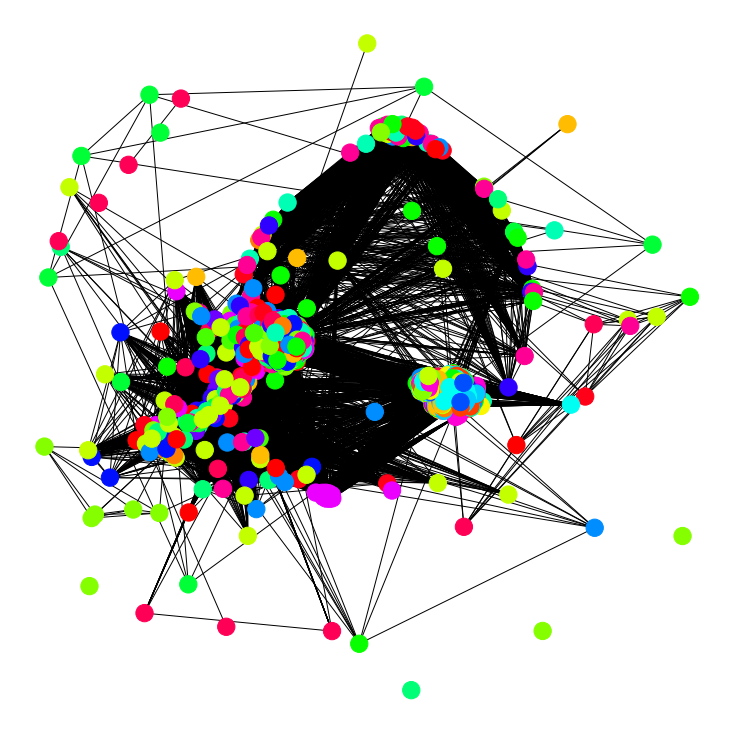

In [19]:
plt.rcParams['figure.figsize'] = [10, 10]

pos = nx.spring_layout(labeled_file_graph)

nx.draw(labeled_file_graph, pos, node_color=[HSV(class_map[x]) for x in labeled_file_graph.nodes])

In [20]:
# nx.draw(labeled_file_graph, pos, node_color=[HSV(class_map[x]) for x in labeled_file_graph.nodes])

# for x in labeled_file_graph.edges(data=True):
#     ew = x[2].get('weight')*1000
#     nx.draw_networkx_edges(labeled_file_graph, pos, edgelist=[(x[0], x[1])], width=ew)


In [21]:
train_graph = labeled_file_graph.copy()

split = 0.1
test_nodes = []
for i in labeled_file_graph.nodes():
    if random.uniform(0, 1) <= split:
        test_nodes.append(i)


train_graph.remove_nodes_from(test_nodes)

In [22]:
# nx.draw(train_graph, node_color=[HSV(class_map[x]) for x in train_graph.nodes])

In [23]:
print(len(train_graph.nodes()), len(labeled_file_graph.nodes()))

3975 4421


In [24]:
with open('labeled_file_graph.json', 'w') as fp:
    json.dump(nx.node_link_data(labeled_file_graph), fp)

Deepwalk Implementation

In [25]:
G_attr_matrix = nx.attr_matrix(train_graph, normalized=True)[0]
nodes_to_ids = {}
ids_to_nodes = {}

n_id = 0
for n in train_graph.nodes():
    nodes_to_ids[n] = n_id
    ids_to_nodes[n_id] = n
    n_id += 1

In [26]:
from numpy.random import choice

def choose_neighbor(G_attr_matrix, node):
    node_id = nodes_to_ids[node]
    norm = G_attr_matrix[node_id][0].tolist()[0]
    
    if sum(norm) > 0.98:

        draw = choice(range(G_attr_matrix.shape[0]), 1, p=norm)[0]
    else:
        draw = node_id
    return ids_to_nodes[draw]

In [27]:
walks_per_node = 10
walk_length = 80
walks = []
for node in train_graph:
    node_walks = 0
    while node_walks < walks_per_node:
        walk = [node]
        cur_node = node
        while len(walk) < walk_length:
            next_node = choose_neighbor(G_attr_matrix, cur_node)
            walk.append(next_node)
            cur_node = next_node
        walks.append(walk)
        node_walks += 1

In [28]:
model = Word2Vec(walks, size=128, window=4, min_count=1, sg=1, hs=0, negative=5, ns_exponent=0.75, iter=10)

In [29]:
kas_dict = {}
for scan, node in zip(mg.responses, mg.scanned_nodes):
    if 'scans' in scan:
        kaspersky = scan['scans'].get('Kaspersky')
        if kaspersky:
            result = kaspersky['result']
        else:
            result = None
        kas_dict[node] = result
    else:
        kas_dict[node] = None

In [52]:
vocab = list(model.wv.vocab)
X = model[vocab]
tsne = TSNE(n_components=2, perplexity=10, n_iter=5000)
X_transformed = tsne.fit_transform(X)
# pca = PCA(n_components=2, svd_solver='full')
# X_transformed = pca.fit_transform(X)
df = pd.DataFrame(X_transformed, index=vocab, columns=['x', 'y'])

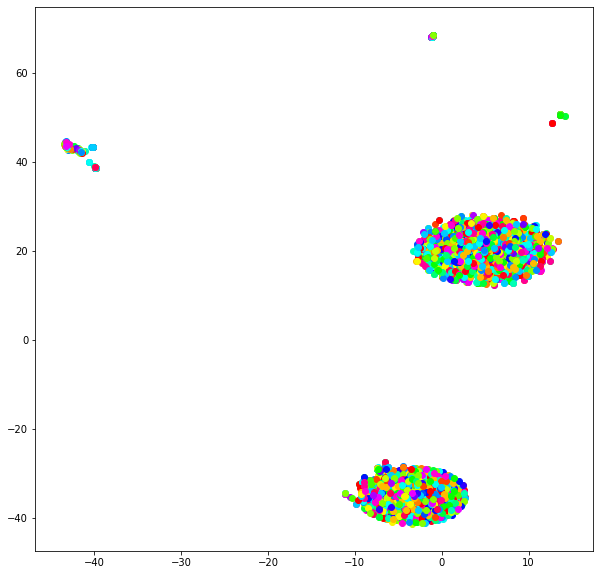

In [31]:
plt.rcParams['figure.figsize'] = [10, 10]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

xs = []
ys = []
classes = []

for word, pos in df.iterrows():
    if word in class_map:    
        pt_color = HSV(class_map[word])
        ax.scatter(pos[0], pos[1], color=pt_color)

In [32]:
# Graph Induction
# Hold out some nodes
# Train CBOW model - given n neighbors predict location

# Generate a number of neighbor samples of that node and feed into model 
# loss is cosine loss between that and current embedding



In [33]:
from collections import Counter
node_label_counts = Counter([sym_dict[n] for n in labeled_file_graph.nodes])

In [34]:
# Use neighborhood average for graph induction
for node in test_nodes:
    av_vector = np.zeros(128)
    n_count = 0
    t_node_count = 0
    neighbor_labels = []
    for neighbor in labeled_file_graph.neighbors(node):
        try:
            av_vector += model.wv[neighbor]
            neighbor_labels.append(sym_dict[neighbor])
            n_count += 1
        except KeyError:
            t_node_count += 1
    av_vector /= n_count
    sims = model.wv.similar_by_vector(av_vector, topn=5)
    
    print(sym_dict[node], [sym_dict[n[0]] for n in sims])

W32.Xpaj.B ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
None ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup!gen20 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Downloader ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Trojan.Gen ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Downloader ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup!gen20 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Chan

None ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Trojan.Gen ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
WS.Reputation.1 ['WS.Reputation.1', None, 'W32.Changeup', 'Trojan.Gen', 'Trojan.Gen']
Trojan.Gen [None, 'Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', 'WS.Reputation.1']
None ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
SecurityRisk.Downldr ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Rahack.H ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Trojan.Gen ['W32.Changeup', 'Trojan.Gen', 'Trojan.Gen', None, 'WS.Reputation.1']
Downloader ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
None ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Spyware.Perfect ['Trojan.

Downloader ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Downloader.Lop ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Downloader ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Trojan.FakeAV!gen92 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
WS.Reputation.1 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Suspicious.Cloud.5 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
WS.Reputation.1 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
SecShieldFraud!gen7 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Trojan.FakeAV!gen93 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen'

W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup!gen20 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Trojan.FakeAV!gen93 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
SecShieldFraud!gen7 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Xpaj.B ['W32.Changeup!gen23', 'W32.Spacefam', 'WS.Reputation.1', 'Trojan.Gen.2', 'WS.Reputation.1']
Downloader ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Downloader ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Downloader ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Trojan.Gen ['Trojan.Gen', 'W32.Changeup', 'Trojan.Ge

WS.Reputation.1 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Trojan.Gen.2 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Trojan.FakeAV!gen92 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Trojan.Gen.2 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
ML.Attribute.HighConfidence ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
ML.Attribute.HighConfidence ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
None ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
W32.Changeup ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
WS.Reputation.1 ['Trojan.Gen', 'W32.Changeup', 'Trojan.Gen', None, 'WS.Reputation.1']
Trojan.Peacomm.D ['Trojan.Peacomm.D', 'W32.Changeup!gen20', 'Downloader', 'Trojan.Malcol', None]
SecurityRisk.ADH ['Trojan.Gen', 'W32.C

In [35]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Conv1D, Conv2D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [36]:
num_neighbors = 64

In [37]:
def generate_train_epoch(train_graph, num_neighbors, model, n_batch, embedding_dim):
    X_train = []
    y_train = []
    for node in train_graph.nodes:
        neighbors = list(train_graph.neighbors(node))
        if len(neighbors) > 0:
            neighbor_sample = choice(neighbors, num_neighbors * n_batch, replace=True)
            fv = model.wv[neighbor_sample[0]]
            neighbor_vecs = model.wv[neighbor_sample]
            neighbor_vecs = np.array(neighbor_vecs).reshape((n_batch, num_neighbors, embedding_dim))
            X_train.append(neighbor_vecs)
            for n in range(n_batch):
                y_train.append(model.wv[node])
    X_train = np.squeeze(np.array(X_train)).reshape((len(y_train), num_neighbors, embedding_dim))
    y_train = np.array(y_train)
    return X_train, y_train

In [38]:
X, y = generate_train_epoch(train_graph, num_neighbors, model, 15, 128)

In [39]:
y.shape

(59505, 128)

In [40]:
X_test = []
final_test_nodes = []
for node in test_nodes:
    neighbors = list(labeled_file_graph.neighbors(node))
    if len(neighbors) > 0:
        neighbor_samples = []
        while len(neighbor_samples) < num_neighbors:
            neighbor_sample = choice(neighbors, 1)
            try:
                neighbor_samples.append(model.wv[neighbor_sample]) 
            except KeyError:
                continue
        X_test.append(neighbor_samples)
        final_test_nodes.append(node)
X_test = np.squeeze(np.array(X_test))

In [41]:
# X_train = np.squeeze(np.array(X_train))
# y_train = np.array(y_train)
# s = np.arange(X_train.shape[0])
# np.random.shuffle(s)
# X_train=X_train[s,:]

In [42]:
n_values = len(train_graph.nodes)
# y_train_oh = np.eye(n_values)[y_train]
# y_train_oh = y_train_oh[s]

In [43]:
cbow_model = Sequential()
cbow_model.add(Flatten(input_shape=(num_neighbors, 128, )))
cbow_model.add(Dense(256, activation='relu'))
cbow_model.add(Dense(128, name='embedding'))
# cbow_model.add(Dense(len(train_graph.nodes), activation='softmax'))

cbow_model.summary()

cbow_model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
embedding (Dense)            (None, 128)               32896     
Total params: 2,130,304
Trainable params: 2,130,304
Non-trainable params: 0
_________________________________________________________________


In [44]:
X_train, y_train = generate_train_epoch(train_graph, num_neighbors, model, 80, 128)

In [114]:
history = cbow_model.fit(X_train, y_train,
                          batch_size=2048,
                          epochs=10,
                         verbose=1,
                         shuffle=True)

Train on 317360 samples
Epoch 1/10
317360/317360 [==============================] - 10s 30us/sample - loss: 0.0326 - accuracy: 0.0874
Epoch 2/10
317360/317360 [==============================] - 10s 32us/sample - loss: 0.0326 - accuracy: 0.0875
Epoch 3/10
317360/317360 [==============================] - 9s 30us/sample - loss: 0.0326 - accuracy: 0.0876
Epoch 4/10
317360/317360 [==============================] - 9s 30us/sample - loss: 0.0325 - accuracy: 0.0876
Epoch 5/10
317360/317360 [==============================] - 9s 30us/sample - loss: 0.0325 - accuracy: 0.0875
Epoch 6/10
317360/317360 [==============================] - 9s 30us/sample - loss: 0.0324 - accuracy: 0.0876
Epoch 7/10
317360/317360 [==============================] - 9s 30us/sample - loss: 0.0324 - accuracy: 0.0878
Epoch 8/10
317360/317360 [==============================] - 10s 30us/sample - loss: 0.0323 - accuracy: 0.0877
Epoch 9/10
317360/317360 [==============================] - 10s 30us/sample - loss: 0.0323 - accuracy

In [115]:
from tensorflow.keras.models import Model
intermediate_layer_model = Model(inputs=cbow_model.input,
                                 outputs=cbow_model.get_layer('embedding').output)
intermediate_output = intermediate_layer_model.predict(X_test)

In [121]:
topn = 10
correct = 0
mrr = 0
for vec, node in zip(intermediate_output, final_test_nodes):
    real_neighbors = list(labeled_file_graph.neighbors(node))
    sims = model.wv.similar_by_vector(vec, topn=topn)
    for idx, n in enumerate(sims):
        if n[0] in real_neighbors:
            correct += 1
            mrr += 1/(idx+1)
print(correct/(topn*len(final_test_nodes)))
print(mrr/(topn*len(final_test_nodes)))

0.5132286995515695
0.16074489287493793


In [117]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
pca.fit(X)  

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [118]:
real_neighbors = list(labeled_file_graph.neighbors(best_node))
sims = model.wv.similar_by_vector(best_vec, topn=topn)
    
projected = pca.transform(best_vec.reshape((1, -1)))
neighbor_points = pca.transform([model.wv[w].tolist() for w in real_neighbors if w in model.wv.vocab])
most_similar_points = pca.transform([model.wv[w[0]].tolist() for w in sims])

non_neighbors = pca.transform([model.wv[w].tolist() for w in choice(list(train_graph.nodes()), 20) if w not in real_neighbors]
                             
                             )

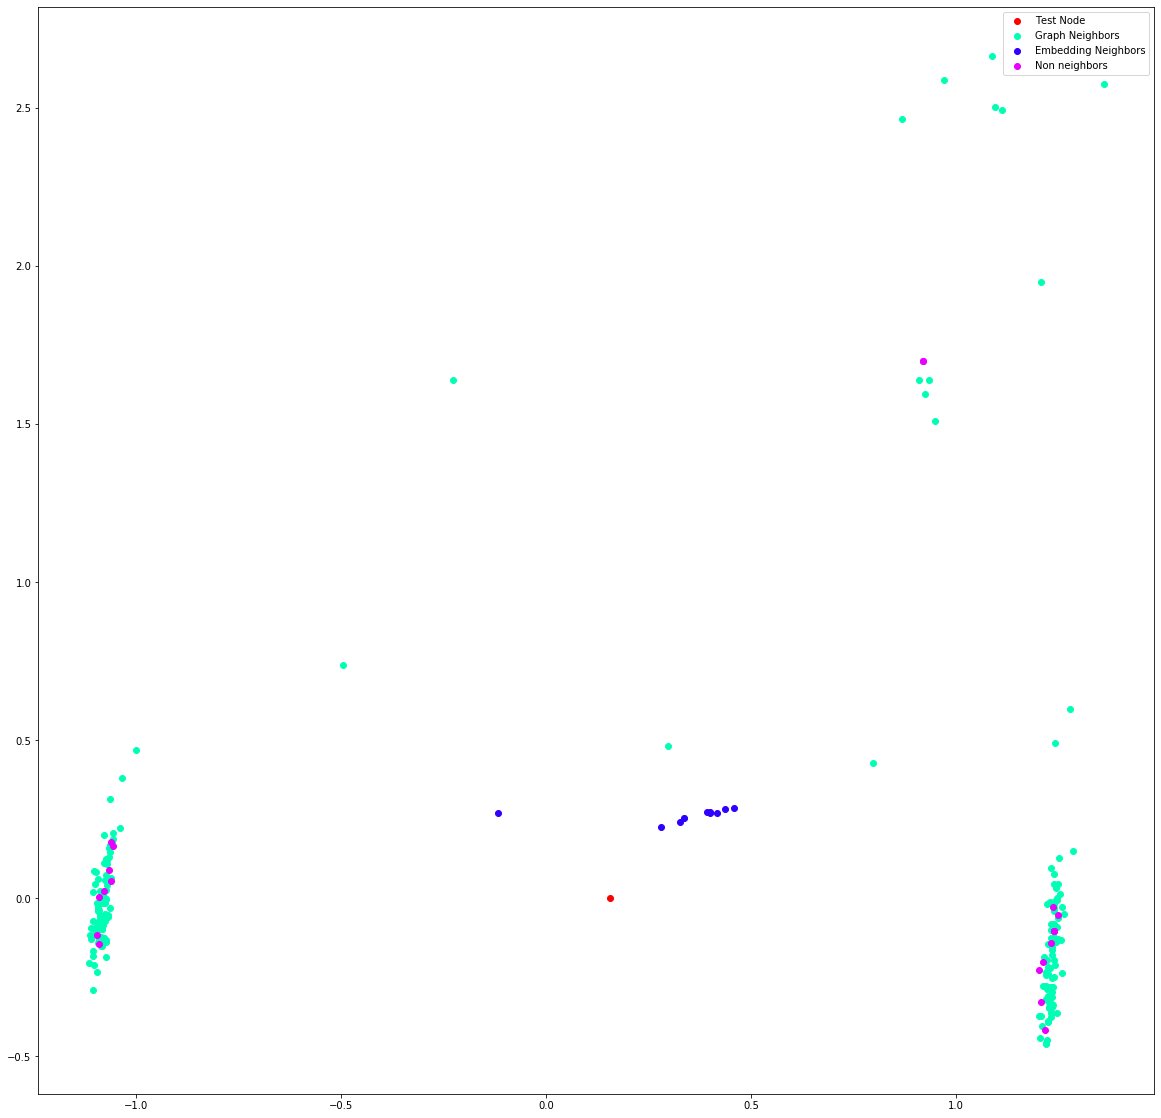

In [119]:
plt.rcParams['figure.figsize'] = [20, 20]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

pt_color = HSV(0)
ax.scatter(projected[0][0], projected[0][1], color=pt_color, label='Test Node')

pt_color = HSV(11)
ax.scatter(neighbor_points[:,0], neighbor_points[:,1], color=pt_color, label='Graph Neighbors')
    
pt_color = HSV(17)
ax.scatter(most_similar_points[:,0], most_similar_points[:,1], color=pt_color, label='Embedding Neighbors')


pt_color = HSV(20)
ax.scatter(non_neighbors[:,0], non_neighbors[:,1], color=pt_color, label="Non neighbors")

ax.legend()

In [171]:
from sklearn.metrics import f1_score

def f1_micro(y_true, y_pred):
    f1_micro = f1_score(y_true, y_pred, average='micro')
    return f1_micro

def f1_macro(y_true, y_pred):
    f1_macro = f1_score(y_true, y_pred, average='macro')
    return f1_macro


In [175]:
input_shape = (num_neighbors, 128, )
class_model = Sequential()
# class_model.add(Dense(64, activation='relu', ))
class_model.add(Conv1D(256, kernel_size=2,
                 activation='relu',
                 input_shape=input_shape))
class_model.add(MaxPooling1D(pool_size=2, strides=2))
class_model.add(Conv1D(128, 2, activation='relu'))
class_model.add(MaxPooling1D(pool_size=2))
class_model.add(Flatten())
class_model.add(Dropout(0.2))
class_model.add(Dense(32, activation='relu', name='embedding'))
class_model.add(Dropout(0.2))
class_model.add(Dense(25, activation='softmax'))

class_model.summary()

class_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 255, 256)          65792     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 127, 256)          0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 126, 128)          65664     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 63, 128)           0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 8064)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8064)              0         
_________________________________________________________________
embedding (Dense)            (None, 32)              

In [176]:
y_test = np.array([list(to_categorical(class_map[x], num_classes=25)) for x in final_test_nodes])
y_test.shape

(424, 25)

In [177]:
for i in range(20):
    X_train, y_train = generate_train_epoch(train_graph, num_neighbors, model, nodes_to_ids)
    y_train = np.array([class_map[ids_to_nodes[y]] for y in y_train])
#     train_sample = random.sample(range(X_train.shape[0]), 40960)
    history = class_model.fit(X_train, to_categorical(y_train, num_classes=25),
                              batch_size=512,
                              epochs=1,
                             verbose=1,
                             shuffle=True,
                             validation_data=(X_test, y_test))
    predictions = class_model.predict(X_test)
    f1_mic = f1_micro(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
    f1_mac = f1_macro(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
    print(f1_mic, f1_mac)

Train on 3990 samples, validate on 424 samples
3990/3990 [==============================] - 4s 1ms/sample - loss: 6.3893 - accuracy: 0.0624 - val_loss: 3.1390 - val_accuracy: 0.1061
0.10613207547169812 0.007995735607675906
Train on 3990 samples, validate on 424 samples
3990/3990 [==============================] - 3s 700us/sample - loss: 3.1371 - accuracy: 0.0762 - val_loss: 3.0808 - val_accuracy: 0.1061
0.10613207547169812 0.007995735607675906
Train on 3990 samples, validate on 424 samples
3990/3990 [==============================] - 2s 615us/sample - loss: 3.1156 - accuracy: 0.0757 - val_loss: 3.0471 - val_accuracy: 0.1061
0.10613207547169812 0.007995735607675906
Train on 3990 samples, validate on 424 samples
3990/3990 [==============================] - 3s 680us/sample - loss: 3.0967 - accuracy: 0.0672 - val_loss: 3.0133 - val_accuracy: 0.1061
0.10613207547169812 0.007995735607675906
Train on 3990 samples, validate on 424 samples
3990/3990 [==============================] - 2s 609us/s

KeyboardInterrupt: 

In [146]:
# Random Guessing
micro_baseline = []
macro_baseline = []
for run in range(100):
    guesses = []
    for i in np.argmax(y_test, axis=1):
        guess = random.randint(0,25)
        guesses.append(random.randint(0,25))
    guess_mic = f1_micro(np.argmax(y_test, axis=1), guesses)
    guess_mac = f1_macro(np.argmax(y_test, axis=1), guesses)
    micro_baseline.append(guess_mic)
    macro_baseline.append(guess_mac)

In [147]:
np.mean(micro_baseline)

0.037264150943396225

In [148]:
np.mean(macro_baseline)

0.031567196515108226